In [51]:
# Usual imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Python's OS Package
import os

# sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.feature_extraction import stop_words
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, auc, roc_curve, roc_auc_score
from xgboost.sklearn import XGBClassifier
from sklearn import svm


# Table of contents
1. [Introduction](#data)      
    1.1 [Stop Words](#stop)
2. [Modeling](#modeling)                
   2.1 [Train Test Split](#tts)        
   2.2 [TF-idf and Logistic Regression](#logistic)            
   2.3 [TF-idf and RandomForest Classifier](#random)                    
   2.4 [TF-idf and Bagging Classifier](#bagging)                 
   2.5 [TF-idf and KNearestNeighbors Classifier](#knn)            
   2.6 [TF-idf and XGBClassifier](#xgboost)               
3. [Final Model Scores](#scores)                        
   3.1 [ROC AUC Curve](#rocauc)                                    
   3.2 [Distribution](#distribution)             
   3.3 [Term Weights](#weight)
4. [Pickle for Flask App](#pickle)


# Importing Data
<a id = 'data'> </a> 

In [4]:
model_df = pd.read_csv('model_df.csv')
model_df.drop(columns='Unnamed: 0', inplace=True)

In [136]:
model_df['target'].value_counts().sum()

24410

In [7]:
model_df['target'].value_counts(normalize = True)

0    0.766858
1    0.233142
Name: target, dtype: float64

Our dataframe as about a 0.76 and 0.24 separation of emergency and non-emergency tweets. We decided to make the target variable unproportional because if our project was applied to a real-time situation, we assume that the tweets would be proportioned as such.

## Stop Words
<a id = 'stop'> </a> 

The below stop words were added to our list based on our eda investigation. Any term that started with an "x" refers to different punctuation markers in tweets. We removed all terms that referred to the names of the fires that were scraped for our project to remove bias. 

Because of certain celebrities affected by the fires, we also found that we had to add Lebron James and John Cena to the stop words list because they appeared too many times in our sample. _(Lebron James had to evacuate from his home, John Cena donated half a million dollars to the effort of fighting fires)_

In [8]:
custom_stop = list(ENGLISH_STOP_WORDS)
custom_stop.extend(["b'RT","000", "x80", "x82", "x8f", "x99", "x94", "x98", "x99m", "x99s", "x9d", "x9f", "xa5", 
                    "xa6", "xa6'RT", "xa6'b'RT", "xa6'b'", "xb8", "xe2", "xef", "xf0", "amp", 'angele', 'angeles',
                    "b'", "Center", 'center', 'com', "Getty", 'getty', 'gettyfire', "Getty Center", "GettyFire",
                    'kincade', "instagram", "htpps", "http", 'John Cena', "nhttp", "nhttps", 'lebron', 'los', "Los Angeles", "Los Angele",
                    "Los", "Angele", "outfit", 'rd', 'rt', "taco", "tick", "truck", "taco truck", "www", "instagram", 
                    "xa6'b'RT", "xa6'b'", "xa6'RT", "xb8", "x9d", "xef", "x8f", 'http','colorado','co',
                    'springs','waldo','canyon','cofire','rt','boulder','waldocanyonfire', 'highparkfire','denverpost',
                    'denver','colo', 'tickfire', 'tick', 'kincadefire', 'mariafire', 'saddleridge', 
                    'center', 'sonoma', 'sonoma county', 'county' ])

# Modeling
<a id = 'modeling'> </a> 

We decided to stick to a tfidf vectorizer because this transformer focus' on the more rare words within the data. With the Tf-idf model, it puts lower weight on the more common terms that would appear such as "fire", "smoke", etc. By doing this, there will be more emphasis on rare terms that appear in our target classs. All the gridsearches we did below contains Tf-idf as the model transformer; the gridsearches will only focus model estimators

## Train Test Split
<a id = 'tts'> </a> 

In [9]:
X = model_df['text']
y = model_df['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.33, random_state=248)

In [10]:
X_union = model_df[['text', 'sia_positive', 'sia_negative','sia_neutral', 'sia_compound']]
y_union = model_df['target']

X_union_train, X_union_test, y_union_train, y_union_test = train_test_split(X_union, y_union, test_size=0.33, 
                                                                               stratify=y, random_state=248)

We are creating different splits for different models. Half of the splits will contain only text. The other half of the splits will contain text and the sentiment scores

In [11]:
# create functions to group features based on data type
def get_text(data):
    return data['text']

def get_numeric(data):
    return data[['sia_positive', 'sia_negative','sia_neutral', 'sia_compound']]

# create function transformer for text features
get_text_tf = FunctionTransformer(get_text, validate=False)
# create function transformer for numeric features
get_numeric_tf = FunctionTransformer(get_numeric, validate=False)

## TFIDF & Logistic Regression
<a id = 'logistic'> </a> 

In [13]:
pipe_1_lr = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression(solver = 'lbfgs'))
])

pipe_1_lr_params = {
    'tfidf__stop_words': [custom_stop],
    'tfidf__max_features': [300, 500, 1000],
    'tfidf__min_df': [5, 10, 20],
    'tfidf__max_df': [0.85, 0.8, 0.9],
    'lr__C': [0.001, 0.01, 1]
}

gs_1_lr = GridSearchCV(pipe_1_lr,
                   pipe_1_lr_params,
                   cv = 5,
                   verbose = 1,
                   n_jobs=-1)
gs_1_lr.fit(X_train, y_train)
print('gs_1_lr completed')
#-------------------------------------------------------
pipe_2_lr = Pipeline([
    ('union', FeatureUnion([
        ('numeric', get_numeric_tf),
        ('text', Pipeline([
            ('selector', get_text_tf),
            ('tfidf', TfidfVectorizer(stop_words=custom_stop, max_features=1200, ngram_range=(1,2)))
        ]))
    ])),
    ('logreg', LogisticRegression(penalty='l2', C=1, solver = 'lbfgs'))
])

pipe_2_lr_params = {}

gs_2_lr = GridSearchCV(pipe_2_lr, pipe_2_lr_params, cv=5, verbose = 1, n_jobs = -1)
gs_2_lr.fit(X_union_train, y_union_train)
print('gs_2_lr completed')

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   14.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   48.5s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  1.7min finished


gs_1_lr completed
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.7s finished


gs_2_lr completed


C:\Users\Brianna Lytle\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [35]:
gs_1_lr.score(X_train, y_train)

0.9249724837960132

In [38]:
preds1_lr = gs_1_lr.predict(X_test)
preds2_lr = gs_2_lr.predict(X_union_test)
print(f'gs_1_lr training best estimator is {gs_1_lr.score(X_train, y_train)}, gs_1_lr test best score is {gs_1_lr.score(X_test, y_test)}')
print(f'gs_1_lr confusion matrix is \n{confusion_matrix(y_test, preds1_lr)}')
print(f'gs_2_lr training best estimator is {gs_2_lr.score(X_union_train, y_union_train)}, gs_2_lr test best score is {gs_2_lr.score(X_union_test, y_union_test)}')
print(f'gs_2_lr confusion matrix is \n{confusion_matrix(y_union_test, preds2_lr)}')

gs_1_lr training best estimator is 0.9249724837960132, gs_1_lr test best score is 0.9123634558093346
gs_1_lr confusion matrix is 
[[5987  191]
 [ 515 1363]]
gs_2_lr training best estimator is 0.9294362235538706, gs_2_lr test best score is 0.9163356504468719
gs_2_lr confusion matrix is 
[[5984  194]
 [ 480 1398]]


## TFIDF & RandomForest
<a id = 'random'> </a> 

In [15]:
pipe_1_rf = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('rf', RandomForestClassifier())
])

pipe_1_rf_params = {
    'tfidf__stop_words': [custom_stop],
    'tfidf__max_features': [300, 500, 1000],
    'tfidf__min_df': [10, 25, 50],
    'tfidf__max_df': [0.7, 0.8, 0.9],
    'rf__max_depth' : [None, 1, 2],
    
}

gs_1_rf = GridSearchCV(pipe_1_rf,
                   pipe_1_rf_params,
                   cv = 5,
                   verbose = 1,
                   n_jobs=-1)
gs_1_rf.fit(X_train, y_train)
print('gs_1_rf completed')
#------------------------------------------------------
pipe_2_rf = Pipeline([
    ('union', FeatureUnion([
        ('numeric', get_numeric_tf),
        ('text', Pipeline([
            ('selector', get_text_tf),
            ('tfidf', TfidfVectorizer(stop_words=custom_stop, max_features=1200, ngram_range=(1,2)))
        ]))
    ])),
    ('rf', RandomForestClassifier(n_estimators = 10))
])

pipe_2_rf_params = {}

gs_2_rf = GridSearchCV(pipe_2_rf, pipe_2_rf_params, cv=5, verbose = 1, n_jobs = -1)
gs_2_rf.fit(X_union_train, y_union_train)
print('gs_2_rf completed')

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  2.2min finished
C:\Users\Brianna Lytle\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


gs_1_rf completed
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.1s finished


gs_2_rf completed


In [39]:
preds1_rf = gs_1_rf.predict(X_test)
preds2_rf = gs_2_rf.predict(X_union_test)
print(f'gs_1_rf training best estimator is {gs_1_rf.score(X_train, y_train)}, gs_1_rf test best score is {gs_1_rf.score(X_test, y_test)}')
print(f'gs_1_rf confusion matrix is \n{confusion_matrix(y_test, preds1_rf)}')
print(f'gs_2_rf training best estimator is {gs_2_rf.score(X_union_train, y_union_train)}, gs_2_rf test best score is {gs_2_rf.score(X_union_test, y_union_test)}')
print(f'gs_2_rf confusion matrix is \n{confusion_matrix(y_union_test, preds2_rf)}')

gs_1_rf training best estimator is 0.9843463372875138, gs_1_rf test best score is 0.9221698113207547
gs_1_rf confusion matrix is 
[[5948  230]
 [ 397 1481]]
gs_2_rf training best estimator is 0.9904610492845787, gs_2_rf test best score is 0.9155908639523337
gs_2_rf confusion matrix is 
[[5965  213]
 [ 467 1411]]


## TFIDF & Bagging Classifier
<a id = 'bagging'> </a> 

In [16]:
pipe_1_bt = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('bt', BaggingClassifier())
])


pipe_1_bt_params = {
    'tfidf__stop_words': [custom_stop],
    'tfidf__max_features': [1500, 1700, 2000],
    'tfidf__min_df': [35, 37, 42],
    'tfidf__max_df': [0.85, 0.9],
    'bt__n_estimators' : [1, 2, 3],
    'bt__max_samples' : [1, 2, 3],
    'bt__max_features' : [1, 2, 3],
}

gs_1_bt = GridSearchCV(pipe_1_bt,
                   pipe_1_bt_params,
                   cv = 5,
                   verbose = 1,
                   n_jobs=-1)
gs_1_bt.fit(X_train, y_train)
print('gs_1_bt completed')
#---------------------------------------------------
pipe_2_bt = Pipeline([
    ('union', FeatureUnion([
        ('numeric', get_numeric_tf),
        ('text', Pipeline([
            ('selector', get_text_tf),
            ('tfidf', TfidfVectorizer(stop_words=custom_stop, max_features=1200, ngram_range=(1,2)))
        ]))
    ])),
    ('bt', BaggingClassifier())
])

pipe_2_bt_params = {}

gs_2_bt = GridSearchCV(pipe_2_bt, pipe_2_bt_params, cv=5, verbose = 1, n_jobs = -1)
gs_2_bt.fit(X_union_train, y_union_train)
print('gs_2_bt completed')

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 2430 out of 2430 | elapsed: 11.0min finished


gs_1_bt completed
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   32.8s finished


gs_2_bt completed


In [40]:
preds1_bt = gs_1_bt.predict(X_test)
preds2_bt = gs_2_bt.predict(X_union_test)
print(f'gs_1_bt training best estimator is {gs_1_bt.score(X_train, y_train)}, gs_1_bt test best score is {gs_1_bt.score(X_test, y_test)}')
print(f'gs_1_bt confusion matrix is \n{confusion_matrix(y_test, preds1_bt)}')
print(f'gs_2_bt training best estimator is {gs_2_bt.score(X_union_train, y_union_train)}, gs_2_bt test best score is {gs_2_bt.score(X_union_test, y_union_test)}')
print(f'gs_2_bt confusion matrix is \n{confusion_matrix(y_union_test, preds2_bt)}')

gs_1_bt training best estimator is 0.7668460315519139, gs_1_bt test best score is 0.7668818272095332
gs_1_bt confusion matrix is 
[[6178    0]
 [1878    0]]
gs_2_bt training best estimator is 0.9888100770453712, gs_2_bt test best score is 0.903798411122145
gs_2_bt confusion matrix is 
[[5857  321]
 [ 454 1424]]


## TFIDF & KNN
<a id = 'knn'> </a> 

In [17]:
pipe_1_knn = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

pipe_1_knn_params = {
    'tfidf__stop_words': [custom_stop],
    'tfidf__max_features': [1500, 1700, 2000],
    'tfidf__min_df': [35, 37, 42],
    'tfidf__max_df': [0.85, 0.9],
    'knn__n_neighbors': [3, 5, 7],
    'knn__leaf_size': [20, 30, 50],
}

gs_1_knn = GridSearchCV(pipe_1_knn,
                   pipe_1_knn_params,
                   cv = 5,
                   verbose = 1,
                   n_jobs=-1)
    
gs_1_knn.fit(X_train, y_train)
print('gs_1_knn completed')
#--------------------------------------
pipe_2_knn = Pipeline([
    ('union', FeatureUnion([
        ('numeric', get_numeric_tf),
        ('text', Pipeline([
            ('selector', get_text_tf),
            ('tfidf', TfidfVectorizer(stop_words=custom_stop, max_features=1200, ngram_range=(1,2)))
        ]))
    ])),
    ('knn', KNeighborsClassifier())
])

pipe_2_knn_params = {}

gs_2_knn = GridSearchCV(pipe_2_knn, pipe_2_knn_params, cv=5, verbose = 1, n_jobs = -1)
gs_2_knn.fit(X_union_train, y_union_train)
print('gs_2_knn completed')

Fitting 5 folds for each of 162 candidates, totalling 810 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   41.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 12.6min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed: 12.9min finished


gs_1_knn completed
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   13.3s finished


gs_2_knn completed


In [41]:
preds1_knn = gs_1_knn.predict(X_test)
preds2_knn = gs_2_knn.predict(X_union_test)
print(f'gs_1_knn training best estimator is {gs_1_knn.score(X_train, y_train)}, gs_1_knn test best score is {gs_1_knn.score(X_test, y_test)}')
print(f'gs_1_knn confusion matrix is \n{confusion_matrix(y_test, preds1_knn)}')
print(f'gs_2_knn training best estimator is {gs_2_knn.score(X_union_train, y_union_train)}, gs_2_knn test best score is {gs_2_knn.score(X_union_test, y_union_test)}')
print(f'gs_2_knn confusion matrix is \n{confusion_matrix(y_union_test, preds2_knn)}')

gs_1_knn training best estimator is 0.9276018099547512, gs_1_knn test best score is 0.8783515392254221
gs_1_knn confusion matrix is 
[[5941  237]
 [ 743 1135]]
gs_2_knn training best estimator is 0.8789287024581143, gs_2_knn test best score is 0.8402432969215492
gs_2_knn confusion matrix is 
[[6091   87]
 [1200  678]]


## TFIDF & XG Boost
<a id = 'xgboost'> </a> 

In [18]:
pipe_1_xg = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('xg', XGBClassifier())
])

pipe_1_xg_params = {
    'tfidf__stop_words': [custom_stop],
    'tfidf__max_features': [1500, 1700, 2000],
    'tfidf__min_df': [35, 37, 42],
    'tfidf__max_df': [0.85, 0.9],
    'xg__n_estimators': [100, 700, 1500],
    'xg__max_depth':[3,5]
}

gs_1_xg = GridSearchCV(pipe_1_xg, 
                       pipe_1_xg_params, 
                       cv=5, verbose=1, 
                       n_jobs=-1)

gs_1_xg.fit(X_train, y_train)
print('gs_1_xg completed')

#--------------------------------------------

pipe_2_xg = Pipeline([
    ('union', FeatureUnion([
        ('numeric', get_numeric_tf),
        ('text', Pipeline([
            ('selector', get_text_tf),
            ('tfidf', TfidfVectorizer(stop_words=custom_stop, max_features=1200, ngram_range=(1,2)))
        ]))
    ])),
    ('xg', XGBClassifier())
])

pipe_2_xg_params = {}

gs_2_xg = GridSearchCV(pipe_2_xg, pipe_2_xg_params, cv=5, verbose = 1, n_jobs = -1)
gs_2_xg.fit(X_union_train, y_union_train)
print('gs_2_xg completed')

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 19.0min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 42.7min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 53.1min finished


gs_1_xg completed
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.4s finished


gs_2_xg completed


In [42]:
preds1_xg = gs_1_xg.predict(X_test)
preds2_xg = gs_2_xg.predict(X_union_test)
print(f'gs_1_xg training best estimator is {gs_1_xg.score(X_train, y_train)}, gs_1_xg test best score is {gs_1_xg.score(X_test, y_test)}')
print(f'gs_1_xg confusion matrix is \n{confusion_matrix(y_test, preds1_xg)}')
print(f'gs_2_xg training best estimator is {gs_2_xg.score(X_union_train, y_union_train)}, gs_2_xg test best score is {gs_2_xg.score(X_union_test, y_union_test)}')
print(f'gs_2_xg confusion matrix is \n{confusion_matrix(y_union_test, preds2_xg)}')

gs_1_xg training best estimator is 0.9605601076189312, gs_1_xg test best score is 0.9196871896722939
gs_1_xg confusion matrix is 
[[5968  210]
 [ 437 1441]]
gs_2_xg training best estimator is 0.8975785740491623, gs_2_xg test best score is 0.8895233366434955
gs_2_xg confusion matrix is 
[[5935  243]
 [ 647 1231]]


# Final Model Scores
<a id = 'scores'> </a> 

Below is a table that displays all of our models that were tested and a calculation of other rates based on the results of the models' confusion matrix

Model | Train Score | Test Score | Misclassification | Sensitivity | Specificity | Precision |
-------|-------------| --------|-------| ------| ------|----------|
Tf-idf / Logistic Regression |.924972 |.912363| .08764 |.9208 | .87709 | .9691 |
Tf-idf / Logsitic Regression Union |.929436|.916335 | .83664 | .9257 | .87814 | .96859 |
Tf-idf / Random Forest |.984346|.92217 | .077802 | .933743 | .8728 | .86557 |
Tf-idf / Random Forest Union |.990461| .91559 | .08441 | .92739 | .8351 | .86884 |
Tf-idf / Bagging Classifier | .766846 | .766881 | .233119 | .76688 | 0 | 100% |
Tf-idf / Bagging Classifier Union | . 98881 | .903798 | .0963 | .92806 | .8146 | .94804 |
Tf-idf / KNN | .927602 |.878351 | .121649 | .888839 | .82726 | .96164 |
Tf-idf / KNN Union | .878928 | .840243 | .159757 | .83541 | .88627 | .98591 |
Tf-idf / XG Boost | .96056 | .919687 | .08531 | .93177 | .8728 | .966 |
Tf-idf / XG Boost Union | .89758 | .88952 | .11846 | .9017 | .8351 | .96067 |

Based on all calculations and the results of the ROC AUC curve, we find that a model using **Tf-idf and Random Forest Classifier** will display the best results for our web application at this time. The Random Forest classification model may be overfit; however, the model gave us the best accuracy score, missclassification rate, and sensitivity score.

## ROC AUC Cuve
<a id = 'rocauc'> </a> 

In [177]:
from sklearn.metrics import roc_curve, auc, roc_auc_score

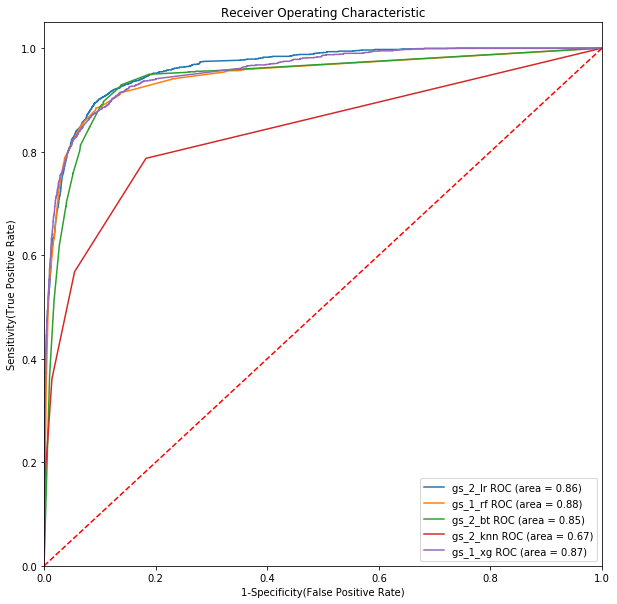

In [59]:
# pos_predict = []
models = [gs_2_lr, gs_1_rf, gs_2_bt, gs_2_knn ,gs_1_xg]
model_names = ['gs_2_lr', 'gs_1_rf', 'gs_2_bt', 'gs_2_knn', 'gs_1_xg']
plt.figure(figsize = (10,10))
for z in range(len(models)):
    if models[z] in [gs_1_rf, gs_1_xg]:
        fpr, tpr, thresholds = roc_curve(y_test, models[z].predict_proba(X_test)[: , 1])
        auc = roc_auc_score(y_test, models[z].predict(X_test))
        plt.plot(fpr, tpr, label= '%s ROC (area = %0.2f)' % (model_names[z], auc))
    else:
        fpr, tpr, thresholds = roc_curve(y_union_test, models[z].predict_proba(X_union_test)[: , 1])
        auc = roc_auc_score(y_union_test, models[z].predict(X_union_test))
        plt.plot(fpr, tpr, label= '%s ROC (area = %0.2f)' % (model_names[z], auc))

# Custom settings for the plot
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## Distribution
<a id = 'distribution'> </a> 

In [113]:
pred_proba = [i[1] for i in gs_1_rf.best_estimator_.predict_proba(X_test)]

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba},
                        )

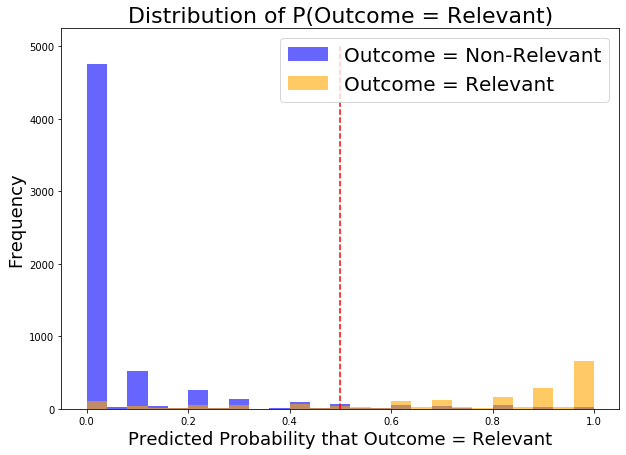

In [132]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = Non-Relevant')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = Relevant')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.5,
           ymin = 0,
           ymax = 5000,
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = Relevant)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = Relevant', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

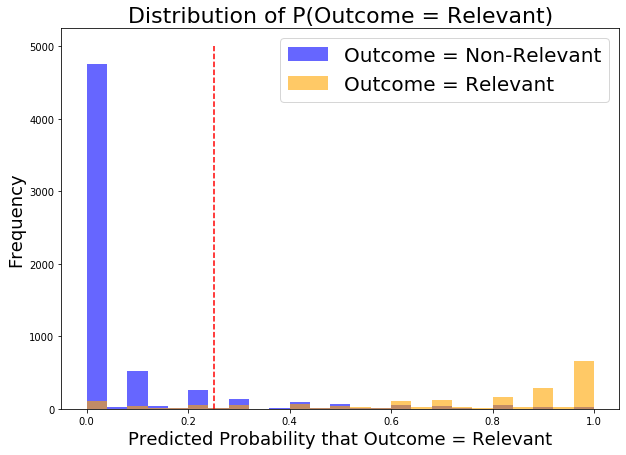

In [131]:
# Create figure.
plt.figure(figsize = (10,7))

# Create two histograms of observations.
plt.hist(pred_df[pred_df['true_values'] == 0]['pred_probs'],
         bins=25,
         color='b',
         alpha = 0.6,
         label='Outcome = Non-Relevant')
plt.hist(pred_df[pred_df['true_values'] == 1]['pred_probs'],
         bins=25,
         color='orange',
         alpha = 0.6,
         label='Outcome = Relevant')

# Add vertical line at P(Outcome = 1) = 0.5.
plt.vlines(x=0.25,
           ymin = 0,
           ymax = 5000,
           color='r',
           linestyle = '--')

# Label axes.
plt.title('Distribution of P(Outcome = Relevant)', fontsize=22)
plt.ylabel('Frequency', fontsize=18)
plt.xlabel('Predicted Probability that Outcome = Relevant', fontsize=18)

# Create legend.
plt.legend(fontsize=20);

Below is a confusion matrix with a new threshold of 0.25 rather than 0.5. 

In [123]:
predicted_probs = gs_1_rf.best_estimator_.predict_proba(X_test)
threshold = 0.25
thresh_preds = (predicted_probs[:,1] >= threshold).astype('int')

In [124]:
matrix2 = confusion_matrix(y_test, thresh_preds)

In [125]:
cm_df2 = pd.DataFrame(matrix2, columns=['Pred Non-rev', 'Pred rev'],
            index = ['Actual Non-rev', 'Actual rev'])
cm_df2

,Pred Non-rev,Pred rev
Actual Non-rev,5606,572
Actual rev,222,1656


In [129]:
print(f'The Sensitivity score with a 0.25 threshold is {1656 / (1656+222)}')
print(f'The Specificity score with a 0.25 threshold is {5606 / (5606 + 572)}')

The Sensitivity score with a 0.25 threshold is 0.8817891373801917
The Specificity score with a 0.25 threshold is 0.9074134023955973


With this new threshold, it increases the sensitivity score which means we are reducing the amount of false negatives

## Most valuable terms
<a id = 'weight'> </a>

In [102]:
def what_importance(model):
    features = model.best_estimator_.named_steps['tfidf'].get_feature_names()
    scores = model.best_estimator_.named_steps['rf'].feature_importances_
    table = {'words': features, 'importance': scores}
    return pd.DataFrame(table).sort_values(by = 'importance', ascending = False).head(10)


what_importance(gs_1_rf)

,words,importance
426,https,0.072318
888,twitter,0.034537
941,winds,0.025888
460,kincade,0.022349
31,acres,0.019505
800,status,0.017127
574,near,0.015504
174,colorado,0.015450
191,county,0.015280
122,brush,0.014894


# Pickling for Web Application
<a id = 'pickle'> </a> 

In [60]:
import pickle
pickle.dump(gs_1_rf, open('model.p', 'wb+'))